<center>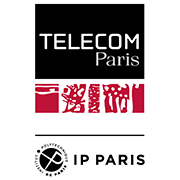</center>

<h1><center><strong><font color='crimson'>
  IA 717: Poetry Generation Project
</font></strong></center></h1>

<center>
  <h3> Project Supervisor <br/> Cyril Chhun</h3>
  <email>cyril.chhun@telecom-paris.fr</email>
  <br/>
  Year 2021-2022
</center>

<h3><center><font color='cornflowerblue'><strong>
    Student Version  
</strong></font></center></h3>

<student><center>

  Ramzi Khalifa
  <br/>Louis-Gabriel Pouillot
  <br/>Yann Rodriguez
</student></center>

# **PRE-PROCESSING**

---
# <font color="crimson">__SETUP__</font>

## __Packages__

In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pprint
import string
import random
import spacy
import torch
import nltk
import time
import math
import os
import sys

# for display
import json
import pandas as pd
import plotly.express as px

# timezone for timestamp
import datetime
import pytz 

import re

# garbage collector of collab
import gc

pp = pprint.PrettyPrinter()


## __Mount drive google & setup cuda/cpu device__

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
  # drive.mount("/content/drive", force_remount=True)


# Use CUDA if on a GPU :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = str(device)
print("Using device : " , device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device :  cpu


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
def clean_memory():
  gc.collect()
  torch.cuda.empty_cache()

clean_memory()

## __Paths__

Adapt your path accordingly 

In [5]:
if IN_COLAB:
    ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/'
else:
    ROOT_PATH = './'

DRAMACODE_PATH  = os.path.join(ROOT_PATH, 'dramacode.github.io')
NAKED_PATH = os.path.join(DRAMACODE_PATH , 'naked')
NAKED_CLEAN_PATH = os.path.join(DRAMACODE_PATH, 'naked_clean')
NAKED_POSTAGGED_PATH = os.path.join(DRAMACODE_PATH, 'naked_pos_tagged')

CORPUS_PATH = os.path.join(ROOT_PATH , 'dramacode_corpus')
CHECKPOINT_PATH = os.path.join(ROOT_PATH, 'dramacode_checkpoints')




## __Params__

### Setup

Choose the mode uncommenting according to you needs

* Build a clean version of source 'naked' files
* Build the file corpus.txt
* Build the file normalized_corpus.txt (alexandrins completed with paddings


In [6]:
# 1. Alexandrine selection wiht plint or standard
USE_PLINT=False
 
# 2. Choose the mode (exclusive, first true gets it all)

MODE="BUILD CLEAN FILES"
# MODE="BUILD STANDARD"   
# MODE="BUILD NORMALIZED"  

# 3. max normalize length
MAX_NORMALIZE=15


TEST_MODE = False # TO CHECK
DEBUG = True


### Notice
No need to change anything below. Do it on previous setup cell

In [7]:
if MODE == "BUILD CLEAN FILES":
  BUILD_DATASET = False
  NAKED_FILES_ALREADY_CLEANED=False
  USE_CLEAN_NAKED_FILES=True
  NORMALIZE_CORPUS=False

elif MODE == "BUILD STANDARD":
  BUILD_DATASET = True
  NAKED_FILES_ALREADY_CLEANED=True
  USE_CLEAN_NAKED_FILES=True
  NORMALIZE_CORPUS=False

elif MODE == "BUILD NORMALIZED":
  BUILD_DATASET = True
  NAKED_FILES_ALREADY_CLEANED=True
  USE_CLEAN_NAKED_FILES=True
  # 1. using a normalized files or not
  NORMALIZE_CORPUS=True

else:
  BUILD_DATASET = False
  NAKED_FILES_ALREADY_CLEANED=True
  USE_CLEAN_NAKED_FILES=True
  NORMALIZE_CORPUS=False



NORMED_PREFIX='' # prefix used for model name and corpus files
if NORMALIZE_CORPUS:
  NORMED_PREFIX = 'normalized_'

PLINT_PREFIX = ""
if USE_PLINT: PLINT_PREFIX="plint_"


FILE_CORPUS  =f"{PLINT_PREFIX}{NORMED_PREFIX}corpus.txt"
FILE_TRAIN   =f"{PLINT_PREFIX}{NORMED_PREFIX}train.txt"
FILE_TEST    =f"{PLINT_PREFIX}{NORMED_PREFIX}test.txt"
FILE_VALID   =f"{PLINT_PREFIX}{NORMED_PREFIX}valid.txt"


if ( BUILD_DATASET and USE_CLEAN_NAKED_FILES) or USE_CLEAN_NAKED_FILES:
  NAKED_PATH = NAKED_CLEAN_PATH

print(f"Using source files from directory {NAKED_PATH.split('/')[-1]}/")



# Params for test mode :
NUM_TEST_FILES_SUBSET = 100
NUM_TEST_ALEXANDRINES = 50

# UNDER DEVELOPMENT
POS_TAGGING = False


print(f"Corpus file names used are : {FILE_CORPUS} and others")


Using source files from directory naked_clean/
Corpus file names used are : corpus.txt and others


In [8]:
if USE_PLINT:
  %pip install plint==0.1
  %pip install haspirater
  %pip install frhyme

In [9]:
if USE_PLINT:
  from plint import verse, template
  import plint.pattern

## __Download data__ *(once)*

In [10]:
# !cd '$ROOT_PATH' && wget -r -A '*.txt' dramacode.github.io/
# !cd '$ROOT_PATH' && mkdir dramacode.github.io/naked_clean
# !cd '$ROOT_PATH' && mkdir dramacode.github.io/naked_pos_tagged

---
# <font color="crimson">__DATA PREPROCESSING__</font>

### Explanations

Now that we have retrieved our data, we will need to preprocess it. There are a few operations we might want to do:
- Filter the files to keep only those which are in alexandrines
- Remove the punctuation or add spaces around
- Put every character to lower case
- Stem the words
- Lemmatize the words
- Remove stop words

Below we will create the functions for each of them. However, you are free to chose which ones you will use; for some, it is difficult to predict if they will improve the results. For others, there are good reasons to choose them, or not. Ideally, you could test every possible combination, but that would take a lot of time.

Just keep in mind that we want to generate **natural** French language.

### Clean naked files

In [39]:
def clean_naked_files():
    """
        Given a list of files of lines, returns the files with clean ups.
        Caution: inverted commas should ideally not be preceded by spaces.
    """
    tot= 0
    file_names = os.listdir(os.path.join(DRAMACODE_PATH , 'naked'))
    for file_name in file_names:
        if DEBUG: print(f"Processing {file_name}")
        source_file_name = os.path.join(DRAMACODE_PATH , 'naked', file_name)
        target_file_name = os.path.join(NAKED_CLEAN_PATH, file_name) 

        lines=""
        with open(source_file_name, 'r') as f:
            lines = f.read()

            # clean dash
            lines = re.sub('–', r'-', lines)
            lines = re.sub('\.{3,}', r'… ', lines)
            lines = re.sub('\. *\. *\.[ \.]{1,}', r'… ', lines)
            lines = re.sub('\. *\. *\.', r'…', lines)

            # wrong ê, é -> ã©crase
            lines = re.sub('Ã', r'Â', lines)
            lines = re.sub('Ã¢', r'â', lines)
            lines = re.sub('Ã ', r'à', lines)

            lines = re.sub('ãª', r'ê', lines)
            lines = re.sub('ã©', r'é', lines)
            lines = re.sub('Ãª', r'ê', lines)
            lines = re.sub('Ã©', r'é', lines)
            lines = re.sub('Ã', r'É', lines)

            
            lines = re.sub('Ã', r'Ê', lines)
            lines = re.sub('Ã¨', r'è', lines)
            lines = re.sub('Â"', r'"', lines)
            lines = re.sub('Â ', r' ', lines)
            # lines = re.sub('', r'', lines)
            lines = re.sub('Ã®', r'î', lines)

            lines = re.sub('Ã´', r'ô', lines)
            
            lines = re.sub('Ã', r'Ô', lines)
            
            lines = re.sub('Ã\"', r'û', lines)
            # lines = re.sub('Ã"', r'û', lines)
            lines = re.sub('Ã§', r'ç', lines)

            # lines = re.sub('ã\u0089', r'é', lines)
            #       ã<U+0089>coutez-moi
            #       
            # <U+0080>ce

            #  standardize double quotes
            lines = re.sub('[“”«»]', r'"', lines)

            # strange char  removal
            lines = re.sub('', r'', lines)
            
            # standardize single quotes
            lines = re.sub('[’]', r"'", lines) # add <U+0095>

            # Digits
            lines = re.sub('0([hru])', r'O\1', lines)
            lines = re.sub('0(\w)', r'\1', lines)
            lines = re.sub('1(\w)', r'l', lines)
            lines = re.sub('2([cçdflprst])', r'é\1', lines)
            lines = re.sub('3([ET])', r'\1', lines)
            lines = re.sub('([mL])4', r"\1'", lines)
            lines = re.sub('4t', r"êt'", lines)
            lines = re.sub('([mL])4', r"\1'", lines)
            lines = re.sub(' [68]c ', r" & ", lines)
            lines = re.sub('6([fimn])', r"-\1", lines)
            lines = re.sub(' 7A', r'è', lines)
            lines = re.sub('j7e', r"j'e", lines)
            lines = re.sub('7(\w)', r'è', lines)
            lines = re.sub('t8t', r'tôt', lines)
            lines = re.sub('8E', r'E', lines)
            lines = re.sub('t8t', r'tôt', lines)

            # remove words containing digits or combining any char and digits
            # lines = re.sub('\S+\d+\S+', r"", lines)

            # & -> et
            lines = re.sub('&', r" et ", lines)

            # remove digits
            # lines = re.sub('\d+', r" ", lines)

            # # ajout espace avant et après une ponctuation
            # lines = re.sub('([,.;!?:])', r' \1 ', lines)

            # suppression des espaces insécables 
            lines = re.sub("[\u00A0\u00C2\u0084]", r" ", lines)

            # alexandrins sur plusieurs lignes:
            # 
            # Vous m’aymez !  
            # 
            #               Je vous ayme !  
            # 
            #                               Ah ! quel comble d’honneur !  
            lines = re.sub('\n\s*\n\s+(\w)', r' \1', lines)

        with open(target_file_name, 'w') as tf:
            tf.write(lines)

        # remove empty lines
        with open(target_file_name) as f:
            lines = "".join(line for line in f if not line.isspace())

        with open(target_file_name, 'w') as tf:
            tf.write(lines)


Note that syncing of files to GDrive is done asynchronously. Check there are all copied before using them.


In [41]:
if NAKED_FILES_ALREADY_CLEANED:
  print("Files already cleaned.")
else:
  print("Cleaning files...")
  clean_naked_files()
  print("Done\n")

  print("!! WARNING !!")
  print("You need to check that the files are all synchronized on google drive as it is done asynchronously")
  

Cleaning files...
Processing dorimond_festindepierre.txt
Processing voltaire_femmequiaraison.txt
Processing nericault_glorieux.txt
Processing moliere_princessedelide.txt
Processing lesagedorneval_ilegougou.txt
Processing thibouville_thelamire.txt
Processing gilbert_rodogune.txt
Processing chabanon_toisondor.txt
Processing piron_ecoleperes.txt
Processing dufresny_dedit.txt
Processing taconet_epouxparchicane.txt
Processing aure_genevieve70.txt
Processing dufresny_departdescomediens.txt
Processing rotrou_dombernarddecabrere.txt
Processing lacalprenede_mortmitrhidate.txt
Processing corneillet_bradamante.txt
Processing regnard_coquette.txt
Processing dugazon_modere.txt
Processing rousseaup_mortdebucephale.txt
Processing racine_mithridate.txt
Processing anonyme_prixdunmoment.txt
Processing archambault_onfaitcequonpeut.txt
Processing benserade_mortachille.txt
Processing campistron_andronic.txt
Processing moliere_misanthrope.txt
Processing dancourt_desolationdesjoueuses.txt
Processing saintaig

### Text filtering

We will only do some basic filtering based for instance on the length of the line.
You could open `corneillep_cid.txt` and check the average length of the lines for example.

In [13]:
# Modified  
def keep_alexandrines_only(lines):
    """
        Given an array of lines, returns the filtered array 
        containing lines which are the most likely to be alexandrines.
    """

    alexandrines=[]
    # Params checked sur fichier contenant des alexandrins
    # OK MAX_SPLIT=12 PAD=11, err_delta=6
    MAX_SPLIT=12
    PAD = 11
    err_delta_upper=6
    err_delta_lower=1
    
    for line in lines :
        if len(line.split())>MAX_SPLIT: 
            pass
        else:
          # caractère acentués ajout
          bin = [1 if char in 'aeiouyàäéèêïîôûù' else 0 for char in line]
          comb = np.array([bin[:-1],bin[1:]]).reshape(-1,2)
          nb_syllabe = abs(comb@np.array([1,-1])).sum()/2
          

          if nb_syllabe<=PAD+err_delta_upper and nb_syllabe>=PAD-err_delta_lower:
              alexandrines.append(line)

    return alexandrines


In [14]:
def test_keep_alexandrines_only():
    """ideally, the first section should have much fewer lines than the second part"""
    print("--- NOT ALEXANDRINES ---")
    with open(os.path.join(NAKED_PATH, "allainval_ecoledesbourgeois.txt")) as fin:
        test_lines = keep_alexandrines_only(fin.readlines()[:50])
        for line in test_lines:
            print(line)
    print("\n--- ALEXANDRINES ---")
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = keep_alexandrines_only(fin.readlines()[:50])
        for line in test_lines:
            print(line)

# test_keep_alexandrines_only()  # feel free to comment once you're satisfied

#### Expected result

```
--- NOT ALEXANDRINES ---
Est-ce que tu songes encore à Damis ?
Madame, voilà Monsieur Mathieu qui vient d’entrer.
Vous craignez qu’il ne goûte pas cette alliance ?
Oh ! Mademoiselle n’en tient point.
Il ne donnera jamais son consentement.

--- ALEXANDRINES ---
Entre tous ces amants dont la jeune ferveur
Adore votre fille, et brigue ma faveur,
Don Rodrigue et Don Sanche à l’envi font paraître
Le beau feu qu’en leurs coeurs ses beautés ont fait naître,
Ce n’est pas que Chimène écoute leurs soupirs
Ou d’un regard propice anime leurs désirs,
Au contraire pour tout dedans l’indifférence
Elle n’ôte à pas un, ni donne d’espérance,
Et sans les voir d’un oeil trop sévère, ou trop doux,
C’est de votre seul choix qu’elle attend un époux.
Elle est dans le devoir, tous deux sont dignes d’elle,
Tous deux formés d’un sang, noble, vaillants, fidèle,
Jeunes, mais qui font lire aisément dans leurs yeux
L’éclatante vertu de leurs braves aïeux.
Don Rodrigue sur tout n’a trait en son visage
Qui d’un homme de Cour ne soit la haute image,
Et sort d’une maison si seconde en guerriers,
Qu’ils y prennent naissance au milieu des lauriers,
La valeur de son père, en son temps sans pareille,
Tant qu’a duré sa force a passé pour merveille,
Ses rides sur son front ont gravé ses exploits
Et nous disent encor ce qu’il fut autrefois :
Je me promets du fils ce que j’ai vu du père,
Et ma fille en un mot peut l’aimer et me plaire.
Va l’en entretenir, mais dans cet entretien
Cache mon sentiment et découvre le sien,
Je veux qu’à mon retour nous en parlions ensemble ;
L’heure à présent m’appelle au conseil qui s’assemble,
Le Roi doit à son fils choisir un gouverneur,
Ou plutôt m’élever à ce haut rang d’honneur,
Ce que pour lui mon bras chaque jour exécute,
Me défend de penser qu’aucun me le dispute.
Quelle douce nouvelle à ces jeunes amants !
Et que tout se dispose à leurs contentements !
Et bien, Elvire, enfin, que faut-il que j’espère ?
Que dois-je devenir, et que t’as dit mon père ?
Deux mots dont tous vos sens doivent être charmés,
Il estime Rodrigue autant que vous l’aimez.
L’excès de ce bonheur me met en défiance,
Puisse à de tels discours donner quelque croyance ?
Il passe bien plus outre, il approuve ses feux,
Et vous doit commander de répondre à ses voeux.
```

As you can see, a few lines from the non-verse file sneaked through our rudimentary filter. To improve this, you could for instance compute the percentage of lines kept with respect to the original number of lines: if the ratio is too small, you could choose to keep nothing at all since it is likely that the file is not even in verse.

### Alexandrines checkers

In [15]:
def keep_plint_alexandrines_only(verses,log=False):
    size = 12
    nb_alex = 0
    valid_verses=[]
    for i, ver in enumerate(verses):
        is_valid=False
        try:
          v = verse.Verse(ver, template.Template(), plint.pattern.Pattern(str(size)))
          v.parse()
          is_valid = v.valid()
          if is_valid:
            valid_verses.append(ver)
            nb_alex += 1
        except ValueError:
          print(f'ValueError on verse : <<{ver.strip()}>> - excluded')
        except:
          print(f'Error occurred on verse <<{ver.strip()}>> - excluded')
 
        if log*(not v.valid()): print('Invalid verse: ',ver, end='')
        if (i%5000==0)*(i!=0): print(f'processing verse {i//1000}k/{len(verses)//1000}k ...')
    
    return valid_verses, nb_alex, len(verses)

In [16]:

def test_keep_plint_alexandrines_only(log=False):
    filename = "goulard_agis.txt"
    # filename='dumas_donjuan.txt'
    filepath = os.path.join(NAKED_CLEAN_PATH, filename)
    with open(filepath,'r') as f:
        all_lines = f.readlines()
    verses= all_lines
    verses = ["À mon dernier récit."]

    v, n, l = keep_plint_alexandrines_only(verses, log=log)
    print(v)
    print('Found' , n, '/', l)

if USE_PLINT:
  test_keep_plint_alexandrines_only(log=False)



### Punctuation

#### Explanations

Here we will create functions to either remove punctuation or put spaces around it for better handling later. Let us write both, and you will choose which you want to do. (There is no good or bad answer)

[Relevant documentation](https://docs.python.org/3/library/string.html#string.punctuation).

#### Clean

Clean mostly done in clean_naked_files() 

In [17]:
# # Modified 

def clean_punctuation(lines):
    """
        This may be needed for adjustments.

        We remove unused caracters here
        
        Data was mostly clean in preprocessing of naked files in clean_naked_files()
    """

    cleaned=[]
    for line in lines:
        # remove parenthesis, accolades, strange char  and special chars 
        # change to space        
        line = re.sub('([\(\)\{\}\/\\°…:→§><:])', r' ', line)

        cleaned.append(line)
    return cleaned

#### Punctuation spacing

In [18]:
# Modified 

def space_punctuation(lines):
    """
        given an array of lines, returns the lines with spaced punctuation.
        Caution: inverted commas should ideally not be preceded by spaces.
        For instance, "j'ai faim" should become "j' ai faim".
        
        The str.replace() and str.split() function might help.
    """

    spaced_punct=[]
    for line in lines:
      # ajout espace avant et après une ponctuation
      line = re.sub('([,.;!?…])', r' \1 ', line)

      # ajout d'un espace après une apostrophe
      # line = re.sub('\'', r"' ", line)
      
      spaced_punct.append(line)
    return spaced_punct

In [19]:
def test_space_punctuation():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = space_punctuation(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

# test_space_punctuation()  # feel free to comment once you're satisfied

##### Expected result

```
Entre tous ces amants dont la jeune ferveur
Adore votre fille , et brigue ma faveur ,
Don Rodrigue et Don Sanche à l’ envi font paraître
Le beau feu qu’ en leurs coeurs ses beautés ont fait naître ,
Ce n’ est pas que Chimène écoute leurs soupirs
Ou d’ un regard propice anime leurs désirs ,
Au contraire pour tout dedans l’ indifférence
Elle n’ ôte à pas un , ni donne d’ espérance ,
```


#### Punctuation removal

In [20]:
# Modified

def remove_punctuation(lines):
    """
        given an array of lines, returns the lines without punctuation.
        You might want to keep inverted commas and a space after them, though.
        The str.replace() and str.split() function might help.
    """
    rm_punct=[]
    for line in lines:
      # remplacement des ponctuation par des espaces
      line = re.sub('([,.;!?])', r' ', line)
      # les apostrophes
      line = re.sub('([’\'])', r'\1 ', line)
      # les espaces doubles
      #line = re.sub('\s{2,}', ' ', line)
      rm_punct.append(line)
    return rm_punct

In [21]:
def test_remove_punctuation():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = remove_punctuation(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

# test_remove_punctuation()  # feel free to comment once you're satisfied

##### Expected result

```
Entre tous ces amants dont la jeune ferveur
Adore votre fille et brigue ma faveur
Don Rodrigue et Don Sanche à l’ envi font paraître
Le beau feu qu’ en leurs coeurs ses beautés ont fait naître
Ce n’ est pas que Chimène écoute leurs soupirs
Ou d’ un regard propice anime leurs désirs
Au contraire pour tout dedans l’ indifférence
Elle n’ ôte à pas un ni donne d’ espérance
```

### Lower case

In [22]:
# Modified

def lowercase(lines):
    return [line.lower() for line in lines]

# lowercase(["FdS!E","FQZQFSE"])    

This does not really need testing, since [a function already exists](https://docs.python.org/3/library/stdtypes.html?highlight=lower#str.lower).

### Stemming

You might want to use the NLTK package. [Relevant documentation](https://www.nltk.org/api/nltk.stem.html).

In [23]:
# Modified 

def stem_lines(lines):
    
    stemmer = nltk.stem.snowball.SnowballStemmer("french")
    stemmed_lines = []

    for line in lines:
      stems = []
      tokens = line.split()
      for token in tokens:
        stems.append(stemmer.stem(token))
      stems = ' '.join(stems)
      stemmed_lines.append(stems)

    return stemmed_lines

In [24]:
def test_stem_lines():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = stem_lines(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

# test_stem_lines()  # feel free to comment once you're satisfied

#### Expected result

```
entre tous ce amant dont la jeun ferveur
ador votr fille, et brigu ma faveur,
don rodrigu et don sanch à l’env font paraîtr
le beau feu qu’en leur coeur se beaut ont fait naître,
ce n’est pas que chimen écout leur soupir
ou d’un regard propic anim leur désirs,
au contrair pour tout dedan l’indifférent
elle n’ôt à pas un, ni don d’espérance,
```

### Lemmatization

You might want to use [SpaCy's lemmatizer](https://spacy.io/api/lemmatizer) here.

In [25]:
# pip install https://github.com/explosion/spacy-models/releases/download/fr_core_news_md-2.3.0/fr_core_news_md-2.3.0.tar.gz

In [26]:
# Modified 

def lemmatize_lines(lines):
    nlp = spacy.load('fr_core_news_md')
    lem = []

    for line in lines:
        txt = nlp(line)
        for token in txt:
            lem.append(token.lemma_)
    return lem

In [27]:
def test_lemmatize_lines():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = lemmatize_lines(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

# test_lemmatize_lines()  # feel free to comment once you're satisfied

#### Expected result

```
entre tout ce amant dont le jeune ferveur
Adore votre fille , et brigue mon faveur ,
Don Rodrigue et Don sanche à l’ envi faire paraître
le beau feu qu’ en leur coeur son beauté avoir faire naître ,
ce n’ être pas que chimène écout leur soupir
ou d’ un regard propice anime leur désir ,
au contraire pour tout dedans l’ indifférence
lui n’ ôte à pas un , ni donne d’ espérance ,
```

### POS Tagging (exploratory)

This is done in a separate notebook


### Lenght Normalization

In [28]:
def normalize_len_alex(lines, max_len):
    """
    """
    for i,line in enumerate(lines):
        list_words = line.split()
        len_words = len(list_words)
        
        if len_words <= max_len:
          delta = max_len - len_words
          list_words.extend(['_' for _ in range(delta)])
          list_words.extend('\n')
          lines[i] = ' '.join(list_words)
        else:
          pass
    return lines

### Combining the files

We have several preprocessing functions at our disposal. Now, you can choose which ones you want to use to create the final corpus.

Again, remember that we want to generate **natural** French language.

In [29]:
def get_length_lines(filepath, max_norm=None):
  """
  Returns the lenght of longest words list in lines 
  and the list of lines with max_norm tokens
  """
  max_len = 0
  valid_lines=[]
  with open(filepath,'r') as f:
    all_lines = f.readlines()
    # print(len(all_lines))
    for line in all_lines:
        num_tokens  = len(line.split())
        if num_tokens > max_len:
          max_len = num_tokens
        if max_norm:
          if num_tokens > max_norm:
            # exclure la line
            continue
        valid_lines.append(line)

    if max_norm:
        max_len = min(max_norm, max_len)

  if DEBUG: print(f"Max num of tokens in lines : {max_len}")
  return (max_len, valid_lines)

In [30]:
# Modified

def create_corpus(keep_alex_only=True, use_plint=False, clean_punct=False, space_punct=False, rm_punct=False, lower=True, lem=False, stem=False, normalize=False, extra_prefix=""):

    if TEST_MODE:
      file_names = os.listdir(NAKED_PATH)[:NUM_TEST_FILES_SUBSET]
    else: 
      file_names = os.listdir(NAKED_PATH)

    saving_path = os.path.join(CORPUS_PATH, f'{extra_prefix}{FILE_CORPUS}')
    print(f" to file '{extra_prefix}{FILE_CORPUS}'...")

    print(f'keep_alex_only:\t{keep_alex_only}\n',
          f'use_plint:\t{use_plint}\n',
          f'clean punct:\t{clean_punct}\n',
          f'space_punct:\t{space_punct}\n',
          f'remove punct:\t{rm_punct}\n',
          f'lower case:\t{lower}\n',
          f'lemmatize:\t{lem}\n',
          f'stemming:\t{stem}\n',
          f'normalize:\t{normalize}')
    
    with open(saving_path,'w') as sp:  
        for cpt, file_name in enumerate(file_names) :
            with open(os.path.join(NAKED_PATH, file_name)) as fn:
                if DEBUG: print(f"Processing {file_name} ({len(file_names)-cpt} left)")

                lines = fn.readlines()
                # ugly hack to add an eol on last line
                lines[-1] = lines[-1]+'\n'

                if keep_alex_only:
                  ## Filter alexandrines
                  if TEST_MODE:   lines = keep_alexandrines_only(lines[:NUM_TEST_ALEXANDRINES])
                  elif use_plint: lines, _ , _ = keep_plint_alexandrines_only(lines, log=False)
                  else: lines = keep_alexandrines_only(lines)

                # ## Apply custom clean punctuation ?
                if clean_punct: lines = clean_punctuation(lines)

                # set spaces around punctuation
                if space_punct: lines = space_punctuation(lines)

                ## Remove punct ?
                if rm_punct: lines = remove_punctuation(lines)

                ## Lower case ?
                if lower: lines = lowercase(lines)

                ## Stem words ?
                if stem: lines = stem_lines(lines)

                ## Lemmatize words 
                if lem: lines = lemmatize_lines(lines)

                ## Write
                sp.write(''.join(lines))


    if normalize: 
      # get longest line (in token numbers) from corpus file
      max_len, valid_lines = get_length_lines(saving_path, max_norm=MAX_NORMALIZE)

      with open(saving_path,'w') as sp: 
        lines = normalize_len_alex(valid_lines, max_len)
        ## Write
        sp.write(''.join(lines))



In [31]:
FILE_CORPUS, USE_PLINT

('corpus.txt', False)

In [32]:
# Added
EXTRA_PREFIX=''

if BUILD_DATASET: 
  print('Building corpus', end = "")
  create_corpus(keep_alex_only=True, use_plint=USE_PLINT, clean_punct=False, space_punct=False, lower=False, normalize=NORMALIZE_CORPUS, extra_prefix=EXTRA_PREFIX)
  print('... Done')
  print(f'Syncing file {EXTRA_PREFIX}{FILE_CORPUS} (30 sec)...', end='')
  time.sleep(30)
  print('... Done')
else:
  print('Nothing to do')

Nothing to do


You should obtain a file `corpus.txt`, `normalized_corpus.txt`, `plint_corpus.txt` or `plint_normalized_corpus.txt` which is about 700,000 lines long (but it might be noticeably more or less depending on your filtering choices).

Max num of tokens in lines : 24
24


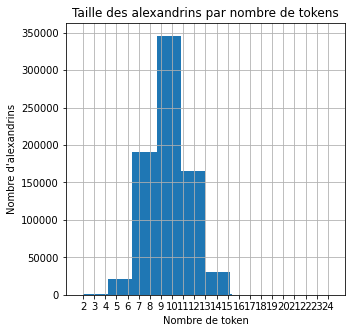

In [33]:
corpus_path = os.path.join(CORPUS_PATH, f'{EXTRA_PREFIX}{FILE_CORPUS}')

with open(corpus_path,'r') as sp:  
    lines_in_corpus = sp.readlines()

if NORMALIZE_CORPUS:
  max_len, all_lines = get_length_lines(corpus_path, max_norm=MAX_NORMALIZE)
else:
  max_len, all_lines = get_length_lines(corpus_path)

print(max_len)
len_alex=[]
for line in lines_in_corpus:
    len_alex.append(len(line.split()))

fig = plt.figure(figsize=(5,5))
labels, counts = np.unique(len_alex, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("Taille des alexandrins par nombre de tokens")
plt.hist(len_alex)
plt.xlabel("Nombre de token")
plt.ylabel("Nombre d'alexandrins")
plt.grid()
plt.show()

In [34]:
print(f"Le nombre d'alexandrins dans le corpus est de {len(lines_in_corpus)}")

Le nombre d'alexandrins dans le corpus est de 754290


### Splitting the data

Now we will split the data in three datasets: `train`, `valid` and `test`. The `train` dataset will be used to train the model, ie, update its parameters. The `valid` dataset will be used to monitor the evolution of the loss during training, and the `test` dataset will be used to evaluate the model after training. We could do without the `test` dataset here since we will be looking at the generated output ourselves, but this is a common procedure so let us follow it.

For instance, every 100 lines could be split as 80 / 10 / 10 or 90 / 5 / 5.

In [35]:
def pack_shuffle(list, size_pack):
    pack_list = [list[size_pack*(i-1):size_pack*i] for i in range(1,len(list)//size_pack+1)]
    random.shuffle(pack_list)
    return [item for sublist in pack_list for item in sublist]

In [36]:
def split_corpus(train_part=0.8, valid_part=0.1, prefix=''):
  """
  Outputs 3 files train.txt, valid.txt and test.txt 
  or normalized_train.txt, normalized_valid.txt and normalized_test.txt
  """
  # split corpus en train, valid et test sets
  corpus_file = os.path.join(CORPUS_PATH, f'{EXTRA_PREFIX}{FILE_CORPUS}')
  train_file = os.path.join(CORPUS_PATH, f'{EXTRA_PREFIX}{FILE_TRAIN}')
  valid_file = os.path.join(CORPUS_PATH, f'{EXTRA_PREFIX}{FILE_VALID}')
  test_file = os.path.join(CORPUS_PATH, f'{EXTRA_PREFIX}{FILE_TEST}')
  
  with open(corpus_file,'r') as f:
      corpus = f.readlines()

      LINES_PER_PACK=400
      corpus = pack_shuffle(corpus, LINES_PER_PACK)
  
  id_train = int(len(corpus)*train_part)
  id_valid = id_train+int(len(corpus)*valid_part)

  with open(train_file,'w') as f:
      f.write(''.join(corpus[:id_train]))

  with open(valid_file,'w') as f:
      f.write(''.join(corpus[id_train:id_valid+1]))

  with open(test_file,'w') as f:
      f.write(''.join(corpus[1+id_valid:]))

In [37]:
f'{EXTRA_PREFIX}{FILE_CORPUS}'

'corpus.txt'

In [38]:
# Added

if BUILD_DATASET: 
  print(f"Splitting corpus {EXTRA_PREFIX}{FILE_CORPUS}...", end="")
  split_corpus()
  print(" Done")
else:
  print("Nothing to do")


Nothing to do
